In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
%matplotlib inline

In [15]:
dataset_train = pd.read_excel("D:\\DATASETS\\GOAT.xlsx")

In [16]:
dataset_train.head()

,district,date,rain,temp_min,temp_max,humidity_min,humidity_max,wind_speed_max,wind_speed_min
0,Adilabad,2018-01-01,0.0,10.4,29.7,41.8,83.8,0.0,5.7
1,Adilabad,2018-01-02,0.0,11.2,34.8,29.8,74.6,0.0,4.8
2,Adilabad,2018-01-03,0.0,17.3,38.0,31.8,71.5,0.0,3.4
3,Adilabad,2018-01-04,0.0,27.3,41.0,24.9,75.6,0.0,7.7
4,Adilabad,2018-01-05,0.0,28.7,43.2,27.7,48.9,0.0,13.5


In [17]:
del dataset_train['district']

In [18]:
f_col=dataset_train.pop('humidity_min')

In [20]:
dataset_train.insert(1,'humidity_min',f_col)

In [21]:
dataset_train.head(5)

,date,humidity_min,rain,temp_min,temp_max,humidity_max,wind_speed_max,wind_speed_min
0,2018-01-01,41.8,0.0,10.4,29.7,83.8,0.0,5.7
1,2018-01-02,29.8,0.0,11.2,34.8,74.6,0.0,4.8
2,2018-01-03,31.8,0.0,17.3,38.0,71.5,0.0,3.4
3,2018-01-04,24.9,0.0,27.3,41.0,75.6,0.0,7.7
4,2018-01-05,27.7,0.0,28.7,43.2,48.9,0.0,13.5


In [22]:
avg=dataset_train['wind_speed_min'].mean()
dataset_train['wind_speed_min'].replace(np.nan,avg,inplace=True)

In [23]:
# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:]

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['date'])

In [24]:
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (1734, 8)
All timestamps == 1734
Featured selected: ['humidity_min', 'rain', 'temp_min', 'temp_max', 'humidity_max', 'wind_speed_max', 'wind_speed_min']


In [25]:
dataset_train = dataset_train[cols].astype(str)
dataset_train = dataset_train.astype(float)
training_set = dataset_train.values
print('Shape of training set == {}.'.format(training_set.shape))

Shape of training set == (1734, 7).


In [26]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.13471942],
       [-0.7016035 ],
       [-0.60712282],
       ...,
       [ 1.22580236],
       [ 1.2446985 ],
       [ 1.47145213]])

In [27]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 365   # Number of days we want top predict into the future
n_past = 550     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (820, 550, 6).
y_train shape == (820, 1).


In [28]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [29]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [30]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 0.9385
Epoch 1: val_loss improved from inf to 0.29933, saving model to weights.h5
3/3 [==============================] - 33s 6s/step - loss: 0.9385 - val_loss: 0.2993 - lr: 0.0100
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.4668
Epoch 2: val_loss did not improve from 0.29933
3/3 [==============================] - 15s 5s/step - loss: 0.4668 - val_loss: 0.5187 - lr: 0.0100
Epoch 3/30
3/3 [==============================] - ETA: 0s - loss: 0.4320
Epoch 3: val_loss did not improve from 0.29933
3/3 [==============================] - 13s 4s/step - loss: 0.4320 - val_loss: 0.3620 - lr: 0.0100
Epoch 4/30
3/3 [==============================] - ETA: 0s - loss: 0.3679
Epoch 4: val_loss did not improve from 0.29933
3/3 [==============================] - 13s 4s/step - loss: 0.3679 - val_loss: 0.3469 - lr: 0.0100
Epoch 5/30
3/3 [==============================] - ETA: 0s - loss: 0.3384
Epoch 5: val_loss did not i

In [31]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [32]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

9/9 [==============================] - 3s 323ms/step


In [33]:
def datetime_to_timestamp(x):
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')

In [34]:
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['humidity_min']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['humidity_min']).set_index(pd.Series(datelist_train[2 *n_past +n_future -1:]))

In [35]:
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN

,humidity_min
2022-01-04,45.840248
2022-01-05,46.746784
2022-01-06,48.301907
2022-01-07,50.736362
2022-01-08,53.939281
...,...
2022-09-26,69.499687
2022-09-27,69.058388
2022-09-28,67.557312
2022-09-29,67.642372


In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
np.sqrt(mean_squared_error(dataset_train['humidity_min'][1464:],PREDICTION_TRAIN))

10.150404245690014

In [38]:
PREDICTIONS_FUTURE

,humidity_min
2022-09-30,56.701580
2022-10-01,56.030964
2022-10-02,54.913033
2022-10-03,53.450569
2022-10-04,51.469955
...,...
2023-09-25,69.499687
2023-09-26,69.058388
2023-09-27,67.557312
2023-09-28,67.642372


In [39]:
dataset_train.index=datelist_train

In [40]:
dataset_train.head(5)

,humidity_min,rain,temp_min,temp_max,humidity_max,wind_speed_max,wind_speed_min
2018-01-01,41.8,0.0,10.4,29.7,83.8,0.0,5.7
2018-01-02,29.8,0.0,11.2,34.8,74.6,0.0,4.8
2018-01-03,31.8,0.0,17.3,38.0,71.5,0.0,3.4
2018-01-04,24.9,0.0,27.3,41.0,75.6,0.0,7.7
2018-01-05,27.7,0.0,28.7,43.2,48.9,0.0,13.5


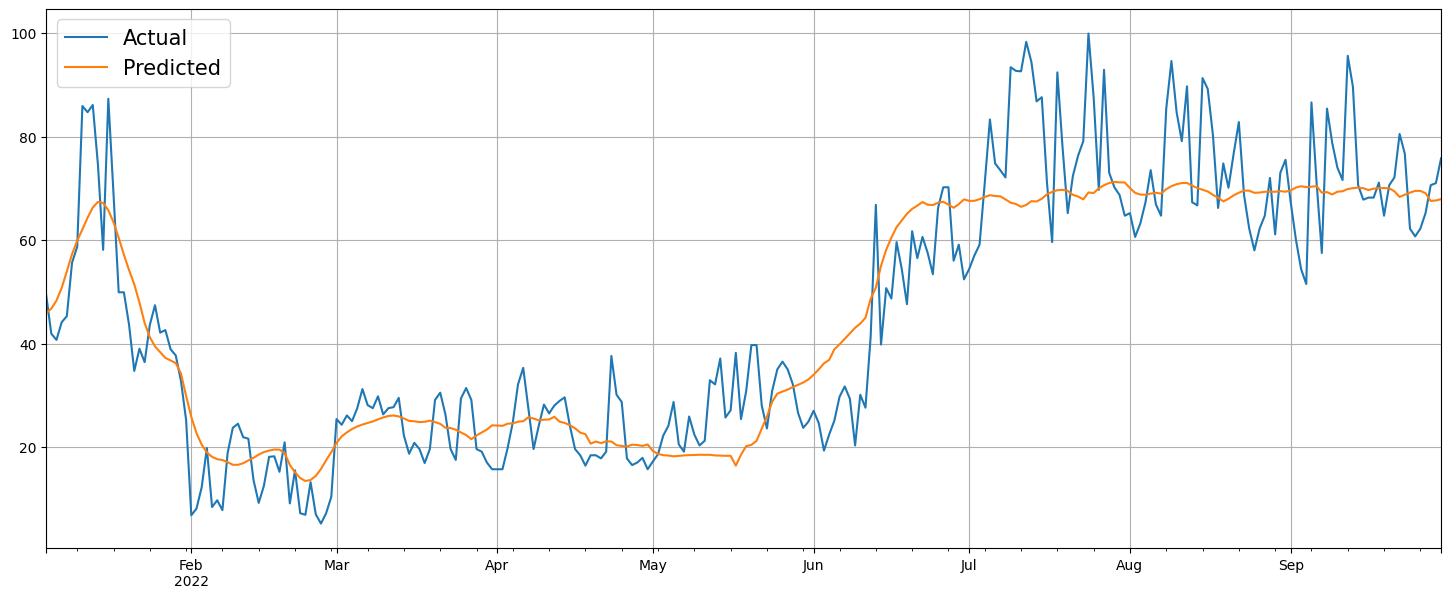

In [41]:
ax=dataset_train['humidity_min']["2022-01-04":"2022-09-30"].plot(figsize=(18,7))
PREDICTION_TRAIN.plot(ax=ax)
plt.legend(['Actual','Predicted'],prop={'size':15})
plt.grid()
plt.show()

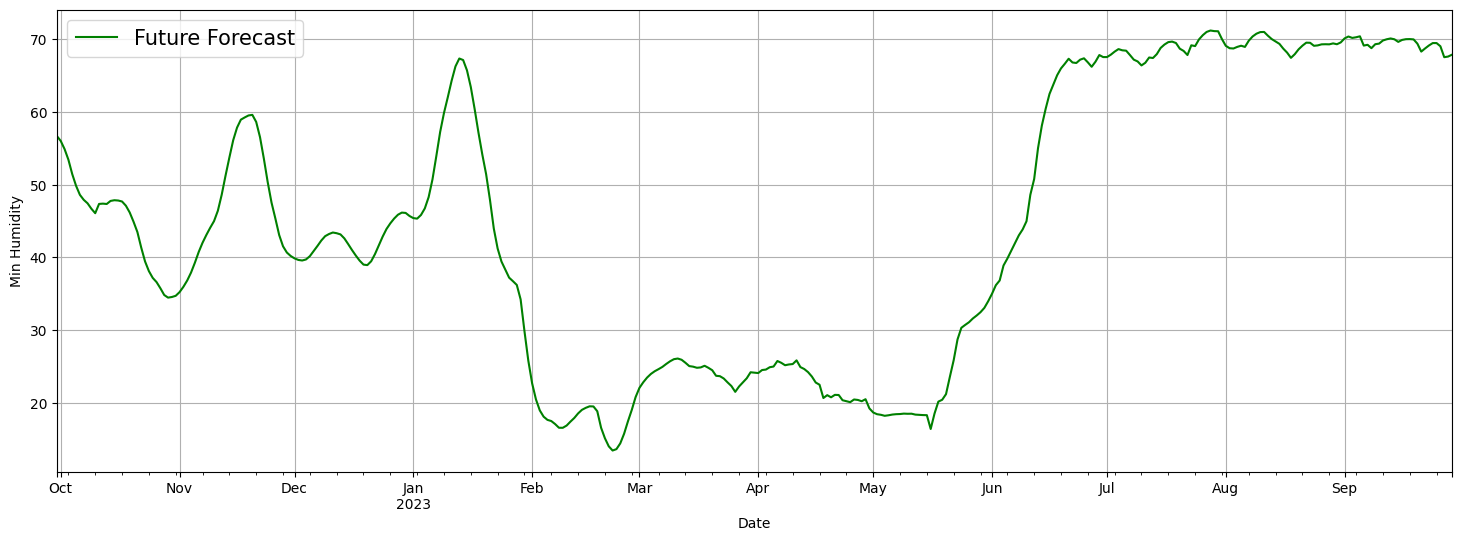

In [42]:
PREDICTIONS_FUTURE.plot(color='green',figsize=(18,6))
plt.xlabel("Date")
plt.ylabel("Min Humidity")
plt.legend(['Future Forecast'],prop={'size':15})
plt.grid()
plt.show()

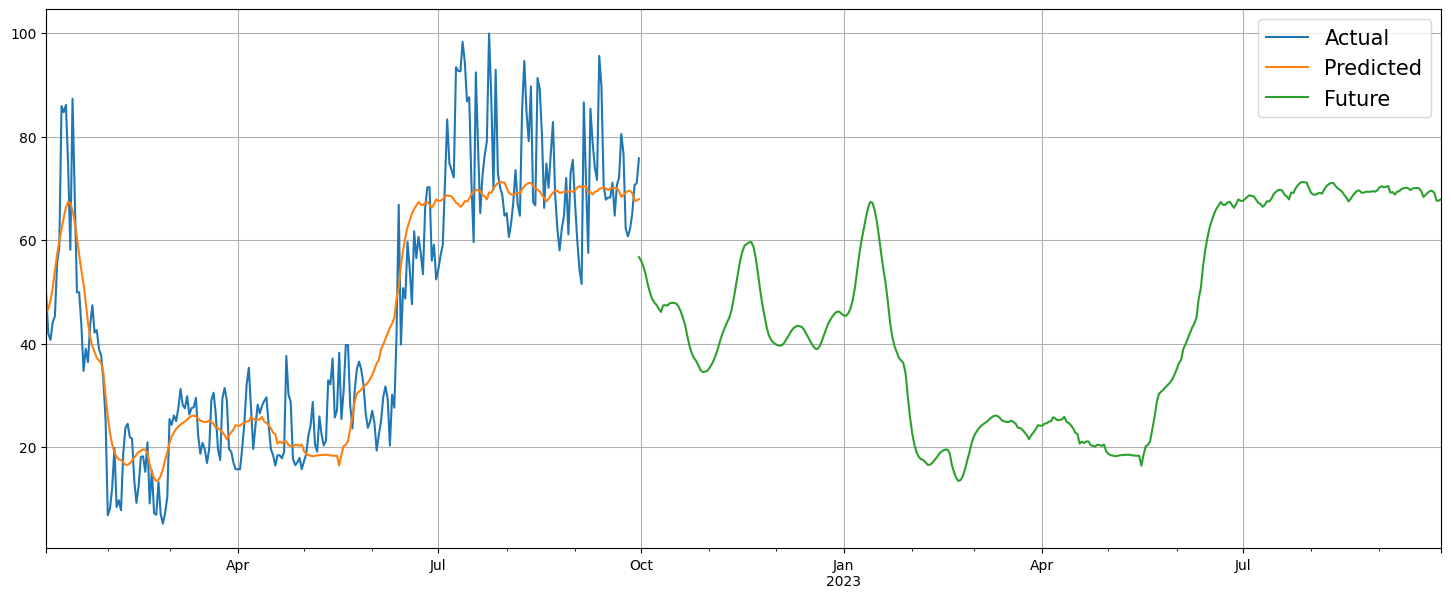

In [43]:
ax=dataset_train['humidity_min']["2022-01-04":"2022-09-30"].plot(figsize=(18,7))
PREDICTION_TRAIN.plot(ax=ax)
PREDICTIONS_FUTURE.plot(ax=ax)
plt.legend(['Actual','Predicted','Future'],prop={'size':15})
plt.grid()
plt.show()